# Analysis

`.csv` files in ...output_YYYY/combo_txts </br>
`.pfb` files in ...output_YYYY/TYPE

TYPES:
> OG <br/>
> LP <br/>
> HP <br/>
> TLE <br/>
> THE <br/>
> MS <br/>
> FS <br/>
> SLR1 <br/>
> SLR2 <br/>
> SLR5 <br/>

YEARS:
> 2005: Average <br/>
> 2001: Dry <br/>
> 1983: Wet <br/>
> 1994: MS <br/>
> 2017: FS <br/>

In [14]:
# Import the ParFlow packages
#
import parflow as pf
from parflow import Run
from parflow.tools.io import write_pfb, read_pfb
from parflow.tools.fs import mkdir, cp, chdir, get_absolute_path, rm, exists
import parflow.tools.hydrology as hydro
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
from glob import glob


# Reaping Info From All Runs

## Reading Data

In [15]:
# all years and single var runs
years = ['1985', '2005', '2019']
parameter = ["OG", "FS", "MS", "HP", "LP", "THE", "TLE", "SLR1", "SLR2", "SLR5"]

# parflow values
mean_flux = {}
plot_flux = {}
vx = {}

# calculated values
groups = {} # number of grouped inflow occurrences
dist_max = {} # maximum distance of SWI for each intrusion event
sub_zero = {} # ct of inflow hours

# parameters, will be determined from the associated forcing files
storms = {}
cum_precip = {}
temp = {}

# iterate through the years and variables, pulling run data from the stored folder
for yr in years:
    for param in parameter:
        base = f'/home/lrgrant/ParFlow/Clements_2D/output/output_{yr}/{param}'
        if os.path.exists(base):
            # set path, pull run data
            os.chdir(base)
            run = Run.from_definition(f'PFCLM_{yr}_{param}.pfidb')  # load the run from the file, this is the same as the run above
    
            # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
            
            # save run data
            data = run.data_accessor # get the data accessor, this makes it easier to access the data from the run
            nt = len(data.times)  # get the number of time steps
            nx = data.shape[2]    # get the number of cells in the x direction
            ny = data.shape[1]    # get the number of cells in the y direction
            nz = data.shape[0]    # get the number of cells in the z direction
            dx = data.dx          # get the cell size in the x direction
            dy = data.dy          # get the cell size in the y direction
            dz = data.dz          # get the cell size in the z direction, this is a 1D array of size nz
            
            porosity = data.computed_porosity.reshape(nz, nx)
            porosity = porosity[:,-1]
            
            # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
            
            print(f"read year {yr}, parameter {param}")
            
            # get a list of all the velocity files in order
            Vx_files = sorted(glob(f"PFCLM_{yr}_{param}.out.velx.*.pfb"))
            
            # read in all pressure files into a 3D NParray
            Vx_arrays = pf.read_pfb_sequence(Vx_files)
            
            # take velocity at coastal boundary (shape of Vx = (nt, nz))
            Vx = Vx_arrays[:,:,0,-1]
            vx[f'{yr}_{param}'] = Vx
            
            flux = (Vx*dz)  # per unit width
        
            # sum over layers for total boundary flux
            plot_flux[f"{yr}_{param}"] = np.sum(flux, axis=1)
    
            # store count of all negative fluxes
            sub_zero[f'{yr}_{param}'] = np.count_nonzero(plot_flux[f"{yr}_{param}"] < 0) 
        
            # store mean flux
            mean_flux[f"{yr}_{param}"] = np.mean(plot_flux[f"{yr}_{param}"])

            # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

            # calculate the number of inflow events
            
            fdata = plot_flux[f'{yr}_{param}'] # flux values
            indices = np.zeros(np.count_nonzero(fdata < 0)) # initializing array of indices of all negative fluxes
            ct = 0
            # filling array of indices of all sub-zero fluxes
            for i in range(8761):
                if fdata[i] < 0:
                    indices[ct] = i
                    ct += 1
            
            negatives = fdata < 0 # boolean array of negative flux values
            change_points = np.diff(negatives.astype(int)) # where flow changes from + --> - or - --> +
            
            # start points: where flux changes from non-negative to negative
            starts = np.where(change_points == 1)[0] + 1  # Adding 1 because diff shifts index by 1
            
            # end points: where flux changes from negative to non-negative
            ends = np.where(change_points == -1)[0]

            # accounting for cases where a year starts or ends with negative flux
            if negatives[0] == True:
                temp_st = np.array([0])
                starts = np.append(temp_st, starts)
            if negatives[-1] == True:
                temp_ed = np.array([8760])
                ends = np.append(ends, temp_ed)
                
            # number of grouped negative fluxes
            groups[f'{yr}_{param}'] = len(ends)
            
            # finding the max. distance of inland travel
            linear_velocity = vx[f'{yr}_{param}'] / porosity
            l = groups.get(f'{yr}_{param}')
            dt = np.ones((l, nz))
            for i in range(l):
                dt[i, :] = np.trapz(linear_velocity[starts[i]:ends[i]], axis=0)
            dist_max[f'{yr}_{param}'] = -np.min(dt,axis=1)

            # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

            # reading + saving info from the forcing file
            # if statements help locate where ff is
            
            if (param == 'THE') or (param == 'TLE'):
                # set path, read file
                base = f"/home/lrgrant/ParFlow/Clements_2D/forcing/forcing_{yr}"
                forcing = glob(base + f'/*forcing*{param}*.txt')[0]

                # store forcing file as df
                df = pd.read_csv(forcing, sep = ' ', header=None)
                df.columns = ["DSWR [W/m2]", "DLWR [W/m2]", "APCP [mm/s]", "Temp [K]", "UGRD [m/s]","VGRD [m/s]","Press [pa]","SPFH [kg/kg]"]

                # storm data (all storm condition hours)
                s = np.where((df["APCP [mm/s]"] * 3600) > 4)[0]

                # cumulative precipitation
                cum_p = np.sum(df["APCP [mm/s]"] * 3600)
                cum_precip[f'{yr}_{param}'] = cum_p

                # mean temperature
                t = np.mean(df["Temp [K]"])
                temp[f'{yr}_{param}'] = t
                
            elif (param != 'OG') and ('SLR' not in param):
                # set path, read file
                forcing = glob(base + '/*forcing*.txt')[0]

                # store forcing file as df
                df = pd.read_csv(forcing, sep = ' ', header=None)
                df.columns = ["DSWR [W/m2]", "DLWR [W/m2]", "APCP [mm/s]", "Temp [K]", "UGRD [m/s]","VGRD [m/s]","Press [pa]","SPFH [kg/kg]"]

                # storm data (all storm condition hours)
                s = np.where((df["APCP [mm/s]"] * 3600) > 4)[0]

                # cumulative precipitation
                cum_p = np.sum(df["APCP [mm/s]"] * 3600)
                cum_precip[f'{yr}_{param}'] = cum_p

                # mean temperature
                t = np.mean(df["Temp [K]"])
                temp[f'{yr}_{param}'] = t
                
            else:
                # set path, read file
                base = f"/home/lrgrant/ParFlow/Clements_2D/forcing/forcing_{yr}"
                forcing = glob(base + f'/forcing1D_{yr}.txt')[0]

                # store forcing file as df
                df = pd.read_csv(forcing, sep = ' ', header=None)
                df.columns = ["DSWR [W/m2]", "DLWR [W/m2]", "APCP [mm/s]", "Temp [K]", "UGRD [m/s]","VGRD [m/s]","Press [pa]","SPFH [kg/kg]"]

                # storm data (all storm condition hours)
                s = np.where((df["APCP [mm/s]"] * 3600) > 4)[0]

                # cumulative precipitation
                cum_p = np.sum(df["APCP [mm/s]"] * 3600)
                cum_precip[f'{yr}_{param}'] = cum_p

                # mean temperature
                t = np.mean(df["Temp [K]"])
                temp[f'{yr}_{param}'] = t


            # # # # # # # # # # # # # # # # # # # # # # # # #
            
            # group the storm condition hours into storm events
            
            storm_starts = []
            storm_lengths = []
            
            current_storm_start = s[0]
            current_storm_length = 1
            
            for i in range(1, len(s)):
                # check if the i is part of the current storm cluster
                if s[i] == s[i-1] + 1:
                    current_storm_length += 1
                else:
                    # if not part of the current storm cluster, add info to storm starts/lengths lists
                    storm_starts.append(current_storm_start)
                    storm_lengths.append(current_storm_length)
                    # re-initialize storm starts
                    current_storm_start = s[i]
                    current_storm_length = 1

            storms[f'{yr}_{param}'] = len(storm_starts)

  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx
read year 1985, parameter OG


/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx
read year 1985, parameter FS


/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx
read year 1985, parameter MS


/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx
read year 1985, parameter HP


/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx
read year 1985, parameter THE


/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx
read year 1985, parameter TLE


/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx
read year 1985, parameter SLR1


/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


read year 1985, parameter SLR2
read year 1985, parameter SLR5
  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx
read year 2005, parameter OG


/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx
read year 2005, parameter FS


/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx
read year 2005, parameter MS


/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx
read year 2005, parameter HP


/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx
read year 2005, parameter LP


/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx
read year 2005, parameter THE


/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx
read year 2005, parameter TLE


/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx
read year 2005, parameter SLR1


/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


read year 2005, parameter SLR2
read year 2005, parameter SLR5
  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx
read year 2019, parameter OG


/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx
read year 2019, parameter FS


/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx
read year 2019, parameter MS


/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx
read year 2019, parameter LP


/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx
read year 2019, parameter THE


/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx
read year 2019, parameter TLE


/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


read year 2019, parameter SLR1
read year 2019, parameter SLR2
read year 2019, parameter SLR5


Repeat for multiple parameter forcings. All multiple parameter forcing runs have flux saved as txt files in folder path: `/home/lrgrant/ParFlow/Clements_2D/output/output_{yr}/combo_txts`

## Sorting Data into pd DataFrame

In [16]:
# find the maximum intrusion event distance of the run
dist_maxMax = {}
for key in dist_max.keys():
    if len(dist_max[key]) > 0:
        dist_maxMax[key] = np.max(dist_max[key])
    else: dist_maxMax[key] = 0 

# find the total intrusion event distances over the run
dist_maxSum = {}
for key in dist_max.keys():
    if len(dist_max[key]) > 0:
        dist_maxSum[key] = np.sum(dist_max[key])
    else: dist_maxSum[key] = 0 

# sort all dicts to ensure same order
mean_flux = dict(sorted(mean_flux.items()))
groups = dict(sorted(groups.items()))
dist_maxMax = dict(sorted(dist_maxMax.items()))
sub_zero = dict(sorted(sub_zero.items()))
storms = dict(sorted(storms.items()))
cum_precip = dict(sorted(cum_precip.items()))
temp = dict(sorted(temp.items()))

# dict to store df info collected above
master_dict = {}
master_dict['mean_flux'] = mean_flux
master_dict['groups'] = groups
master_dict['dist_1x_max'] = dist_maxMax
master_dict['dist_sum'] = dist_maxSum
master_dict['sub_zero'] = sub_zero
master_dict['storms'] = storms
master_dict['cum_precip'] = cum_precip
master_dict['temp'] = temp

# create df, add keys
df = pd.DataFrame.from_dict(master_dict)
df['key'] = mean_flux.keys()

df.head()

,mean_flux,groups,dist_1x_max,dist_sum,sub_zero,storms,cum_precip,temp,key
1985_FS,0.083720,0,0.0,0.0,0,13,881.495083,287.863136,1985_FS
1985_HP,0.117376,0,0.0,0.0,0,33,1336.953871,287.288577,1985_HP
1985_MS,0.093713,0,0.0,0.0,0,28,881.546019,286.117442,1985_MS
1985_OG,0.087428,0,0.0,0.0,0,14,881.469586,287.288577,1985_OG
1985_SLR1,0.060805,0,0.0,0.0,0,14,881.469586,287.288577,1985_SLR1


In [20]:
# store slr for each run
key_list = [key for key in df['key']]
slr = np.zeros(len(key_list))

i = 0
for key in key_list:
    if "SLR" not in key: slr[i] = 0
    elif "SLR1" in key: slr[i] = 0.67
    elif "SLR2" in key: slr[i] = 0.87
    elif "SLR5" in key: slr[i] = 1.08
    i +=1

df['slr'] = slr

# Heat Map Plotting

## Function

In [21]:
'''
sea level rise has 3 options
precipitation has 5 options
this will be our 'outer grid/fixed options'
'''

'''
mapper() is a constructor function for making subplots of larger heatmaps
         it constructs an a heatmap array & x/y label arrays of the target variable for the parameters passed to it

fixed_param_X: parameter at 1 constant value in the subplot 
fixed_val_X: value fixed_param_X is set to
variable_X: variables changing in the heatmap
target_variable: variable in the dataframe we want to heatmap
'''

def mapper(fixed_param_1, fixed_val_1, fixed_param_2, fixed_val_2, variable_1, variable_2, target_variable):
    # create temporary df that holds all the entries for constant values at fixed_param_1 & fixed_param_2
    df_temp = df.loc[df[fixed_param_1] == fixed_val_1]
    df_temp = df_temp.loc[df[fixed_param_2] == fixed_val_2]

    # checking non-empty df
    if df_temp.size == 0:
        return [], [], []
    
    # read in different values for each variable
    v1 = np.unique(df_temp[variable_1])
    v2 = np.unique(df_temp[variable_2])
    # construct meshgrid for the variables
    V1, V2 = np.meshgrid(v1, v2)

    # initialize colormap array
    cmat = -1*np.ones(V1.shape)
    
    # fill colormap array
    for i in range(len(cmat)): # iterates over rows
        for j in range(len(cmat[0])): # iterates over cols
            id2, id1 = V2[i, 0], V1[0, j]
            if len(df_temp.loc[(df_temp[variable_1] == id1) & (df_temp[variable_2] == id2)][target_variable]) == 1:
                cmat[i, j] = df_temp.loc[(df_temp[variable_1] == id1) & (df_temp[variable_2] == id2)][target_variable]

    # rounding output values
    if target_variable == 'sub_zero':
        mask = np.where(cmat != -1)
        mask = np.stack((mask[0], mask[1]), axis=1)
        for i in range(len(mask)):
            idx = mask[i, 0]
            idy = mask[i, 1]
            if cmat[idx, idy] != -1:
                cmat[idx, idy] = np.round(cmat[idx, idy]/8760, 2)
    elif target_variable == 'mean_flux':
        cmat = np.round(cmat, 3)
    elif target_variable == 'dist_1x_max':
        cmat = np.round(cmat, 1)
    elif target_variable == 'dist_sum':
        cmat = np.round(cmat, 1)
    
    # if an entire row of cmat is -1, remove the row
    id_list = np.array([])
    for i in range(len(cmat)):
        if np.all(cmat[i, :] == -1):
            id_list = np.append(id_list, i)
    cmat = np.delete(cmat, id_list.astype(int), 0)
    
    # if an entire row of cmat is -1, remove the row
    id_list = np.array([])
    if cmat.size != 0:
        for i in range(len(cmat[0])):
            if np.all(cmat[:, i] == -1):
                id_list = np.append(id_list, i)
        cmat = np.delete(cmat, id_list.astype(int), 1)

    return cmat, V1[0,:], V2[:,0]

## Running

In [22]:
# def mapper(fixed_param_1, fixed_val_1, fixed_param_2, fixed_val_2, variable_1, variable_2, target_variable):
cmat = {}
x = {}
y = {}

# insert desired variable
var = 'groups'

# run for all values of fixed vars slr and precip
c_ind = 0
for i in range(4):
    for j in range(3):
        cmat[c_ind], x[c_ind], y[c_ind] = mapper('slr', np.unique(df['slr'])[i], 'cum_precip', np.unique(df['cum_precip'])[j], 'temp', 'storms', var)
        print(c_ind, "slr:", i, "precip:", j)
        c_ind += 1

0 slr: 0 precip: 0
1 slr: 0 precip: 1
2 slr: 0 precip: 2
3 slr: 1 precip: 0
4 slr: 1 precip: 1
5 slr: 1 precip: 2
6 slr: 2 precip: 0
7 slr: 2 precip: 1
8 slr: 2 precip: 2
9 slr: 3 precip: 0
10 slr: 3 precip: 1
11 slr: 3 precip: 2


/tmp/ipykernel_804993/2404061145.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cmat[i, j] = df_temp.loc[(df_temp[variable_1] == id1) & (df_temp[variable_2] == id2)][target_variable]
/tmp/ipykernel_804993/2404061145.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cmat[i, j] = df_temp.loc[(df_temp[variable_1] == id1) & (df_temp[variable_2] == id2)][target_variable]
/tmp/ipykernel_804993/2404061145.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cmat[i, j] = df_temp.loc[(df_temp[variable_1] == id1) & (df_temp[variable_2] == id2)][target_variable]
/tmp/ipykernel_804993/2404061145.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

## Making Figures

In [23]:
np.max(df[var]) # set vmax to the maximum value of the target variable

8

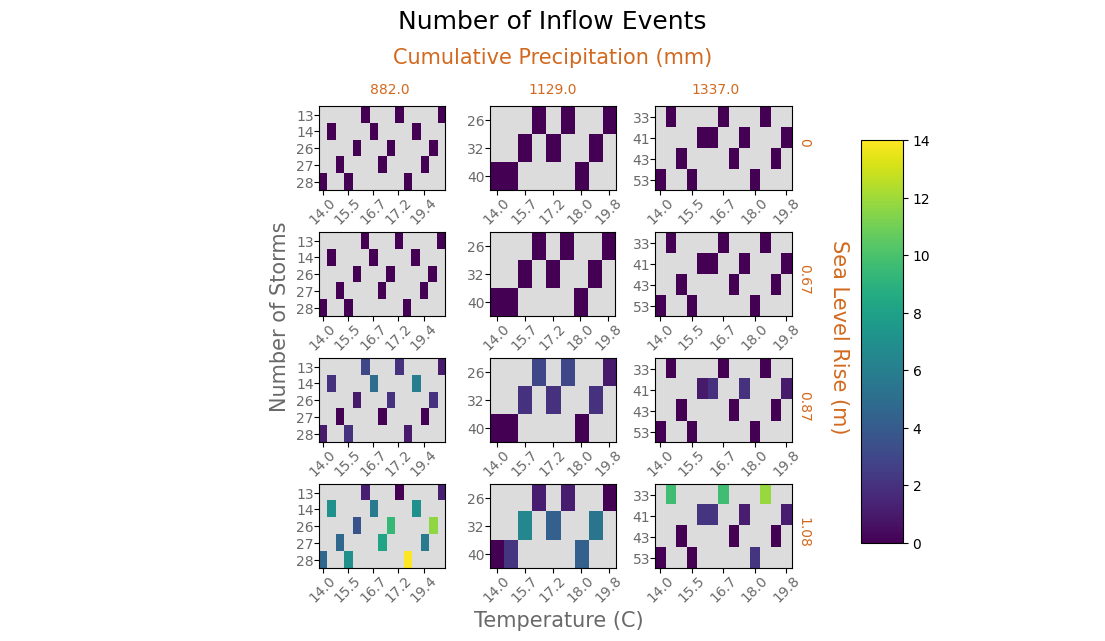

In [628]:
# create figure
fig, ax = plt.subplots(4,3, figsize=(14, 6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.5, wspace=-0.77)

# fill in cubplots
c_index = 0
for i in range(4): # slr
    for j in range(3): # precip
        if len(cmat[c_index] )== 0:
            ax[i, j].axis('off')
            c_index += 1
            continue
        masked_array = np.ma.masked_equal(cmat[c_index], -1)  
        cmap = plt.cm.viridis
        cmap.set_bad('gainsboro',1.)
        ax[i,j].imshow(masked_array, cmap=cmap, vmax=8)
        if len(x[c_index]) > 6:
            tk = np.arange(0,len(x[c_index]),2)
            lbl = x[c_index]
            ax[i,j].set_xticks(ticks=tk, labels=np.round(lbl[tk] - 272.15, 1), rotation=45, color = 'dimgrey')
        else: ax[i,j].set_xticks(ticks=np.arange(0,len(x[c_index]),1), labels=np.round(x[c_index] - 272.15,1), rotation=45, color = 'dimgrey')
        if len(x[c_index]) > 10:
            tk = np.arange(0,len(x[c_index]),3)
            lbl = x[c_index]
            ax[i,j].set_xticks(ticks=tk, labels=np.round(lbl[tk] - 272.15, 1), rotation=45, color = 'dimgrey')
        ax[i,j].set_yticks(ticks=np.arange(0,len(y[c_index]),1), labels=y[c_index], color = 'dimgrey')
        ax[i,j].set_aspect(ax[i,j].get_aspect()*2)
        ax[i,j].tick_params(pad = 0.1)
        c_index += 1

# adjust subplot locations

# find height and width of axis with desired height
bbox = ax[0,0].get_position()
# find height and width of axis whose height we want to change
bbox2 = ax[0,4].get_position()
# get old aspect
asp = bbox2.height / bbox2.width
# new height
height = bbox.height
# new width
width = height/asp

bbox2_new = [bbox2.x0, bbox2.y0, width, height]
ax[0, 4].set_position(bbox2_new)

# set axis labels
ax[0,1].set_title('Temperature (C)', color = 'dimgrey', y = -5.3, x=0.55, fontsize = 15)
ax[1,0].set_ylabel('Number of Storms', color = 'dimgrey', fontsize = 15, y = 0)

# add color bar
bbox_cm = ax[3,0].get_position()
norm = mcolors.Normalize(vmin=0, vmax=8)
cbar_ax = fig.add_axes([bbox2.x0+0.1, bbox_cm.y0 + 0.3*bbox_cm.height, 0.03, bbox2.height*3.5])
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cbar_ax)

# add larger plt labels
fig.add_subplot(111, frameon=False)
x_t = np.linspace(0.35,0.65,3)
plt.xticks(ticks=x_t, labels = [np.unique(df['cum_precip'])[0], np.unique(df['cum_precip'])[1], np.unique(df['cum_precip'])[2]], color='chocolate')
y_t = np.linspace(0.1,0.92,4)
plt.yticks(ticks = y_t, labels=[1.08, 0.87, 0.67, 0], rotation = 270, color='chocolate', x=0.9)
plt.tick_params(pad=-140,axis='y', which='both', labelleft=False, labelright=True, left=False, bottom=False)
plt.tick_params(axis='x', which='both', labelbottom=False, labeltop=True, left=False, bottom=False)

# change title
plt.ylabel("Sea Level Rise (m)", labelpad=-590, rotation=270, fontsize = 15,color='chocolate')
plt.xlabel("Cumulative Precipitation (mm)", fontsize = 15, labelpad=-375, color='chocolate')
plt.title(r"Number of Inflow Events", fontsize=18, y=1.15, x = 0.5)


# plt.savefig('/home/lrgrant/ParFlow/Clements_2D/output/figures/big_grid_groups.pdf')

# Scatters

### sample plots

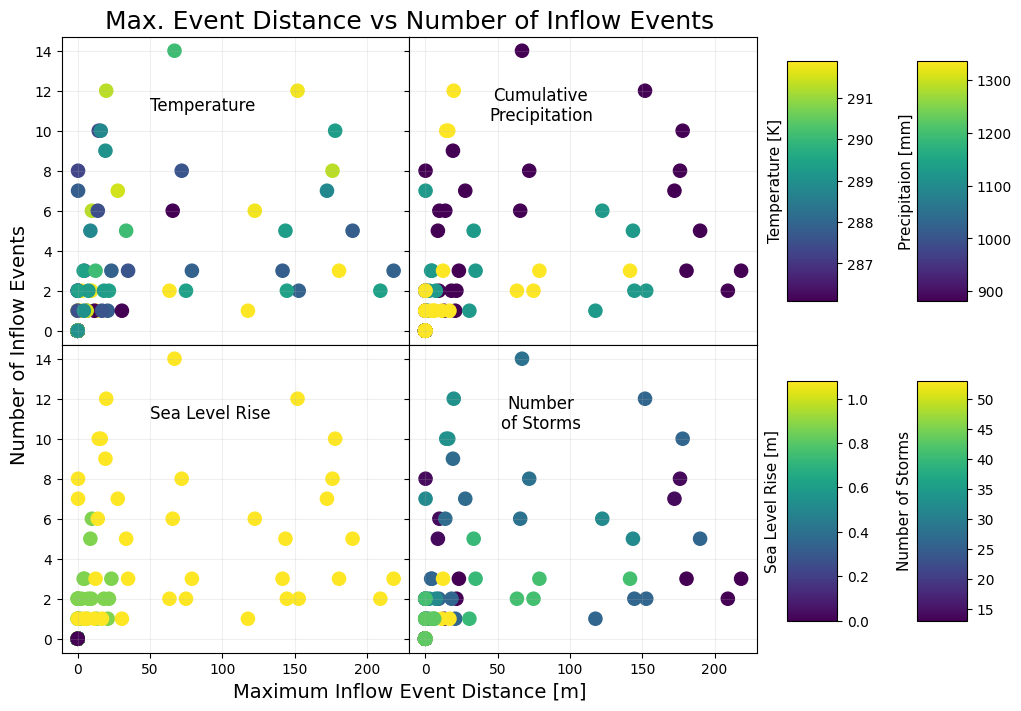

In [928]:
# make figure
fig, ax = plt.subplots(2,2, figsize=(10,8))
plt.subplots_adjust(left=None, bottom=None, right=0.82, top=None, wspace=0, hspace=0)

# make the plots with color maps, label each plot with the color parameter
im1 = ax[0,0].scatter(df['dist_1x_max'], df['groups'], c=df['temp'], s = 90)
ax[0,0].grid(alpha = 0.2)
ax[0,0].set_ylabel("Number of Inflow Events", y = 0, fontsize = 14)
ax[0,0].text(50,11, "Temperature", fontsize=12)

im2 = ax[0,1].scatter(df['dist_1x_max'], df['groups'], c=df['cum_precip'], s = 90)
ax[0,1].grid(alpha = 0.2)
ax[0,1].tick_params(labelleft=False)
ax[0,1].text(80,10.5, "Cumulative\nPrecipitation", fontsize=12, horizontalalignment='center')

im3 = ax[1,0].scatter(df['dist_1x_max'], df['groups'], c=df['slr'], s = 90)
ax[1,0].grid(alpha = 0.2)
ax[1,0].set_xlabel("Maximum Inflow Event Distance [m]", fontsize = 14, x = 1)
ax[1,0].text(50,11, "Sea Level Rise", fontsize=12)

im4 = ax[1,1].scatter(df['dist_1x_max'], df['groups'], c=df['storms'], s = 90)
ax[1,1].grid(alpha = 0.2)
ax[1,1].tick_params(labelleft=False)
ax[1,1].text(80,10.5, "Number\nof Storms", fontsize=12,horizontalalignment='center')

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# add color bars to the figure

cbar_ax1 = fig.add_axes([0.85, 0.55, 0.05, 0.3])
cb1 = fig.colorbar(im1, cax=cbar_ax1)
cb1.set_label('Temperature [K]', rotation=90, labelpad=-76, fontsize=11)

cbar_ax2 = fig.add_axes([0.98, 0.55, 0.05, 0.3])
cb2 = fig.colorbar(im2, cax=cbar_ax2)
cb2.set_label('Precipitaion [mm]', rotation=90, labelpad=-81, fontsize=11)

cbar_ax3 = fig.add_axes([0.85, 0.15, 0.05, 0.3])
cb3 = fig.colorbar(im3, cax=cbar_ax3)
cb3.set_label('Sea Level Rise [m]', rotation=90, labelpad=-75, fontsize=11)

cbar_ax4 = fig.add_axes([0.98, 0.15, 0.05, 0.3])
cb4 = fig.colorbar(im4, cax=cbar_ax4)
cb4.set_label('Number of Storms', rotation=90, labelpad=-70, fontsize=11)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# add plot title

fig.add_subplot(111, frameon=False)
plt.title("Max. Event Distance vs Number of Inflow Events", fontsize=18)
plt.yticks([])
plt.xticks([])

# save plot
# plt.savefig('/home/lrgrant/ParFlow/Clements_2D/output/figures/allparams_dist1x_groups.pdf', bbox_extra_artists=(cbar_ax4, cbar_ax3, cbar_ax2, cbar_ax1,), bbox_inches='tight')

([], [])

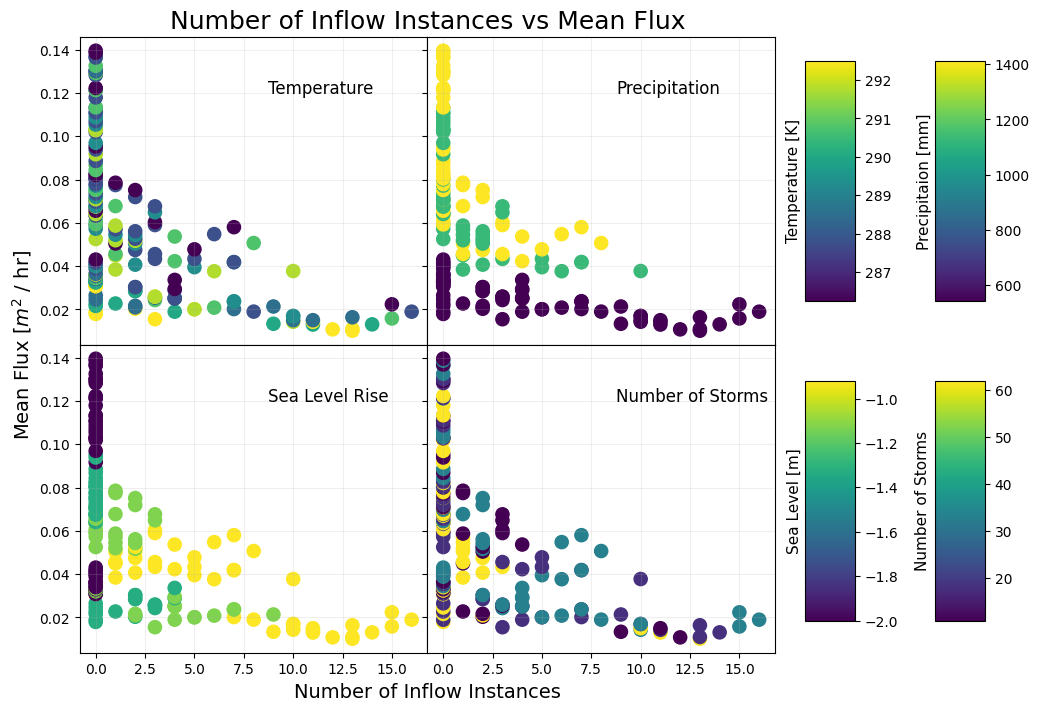

In [492]:
fig, ax = plt.subplots(2,2, figsize=(10,8))
plt.subplots_adjust(left=None, bottom=None, right=0.82, top=None, wspace=0, hspace=0)

im1 = ax[0,0].scatter(groups, mean_flux_all, c=t_all, s = 90)
ax[0,0].grid(alpha = 0.2)
ax[0,0].set_ylabel(r"Mean Flux [$m^2$ / hr]", y = 0, fontsize = 14)
ax[0,0].text(8.75, 0.12, "Temperature", fontsize=12)

im2 = ax[0,1].scatter(groups, mean_flux_all, c=p_all, s = 90)
ax[0,1].grid(alpha = 0.2)
ax[0,1].tick_params(labelleft=False)
ax[0,1].text(8.75, 0.12, "Precipitation", fontsize=12)

im3 = ax[1,0].scatter(groups, mean_flux_all, c=slr_all, s = 90)
ax[1,0].grid(alpha = 0.2)
ax[1,0].set_xlabel("Number of Inflow Instances", fontsize = 14, x = 1)
ax[1,0].text(8.75, 0.12, "Sea Level Rise", fontsize=12)

im4 = ax[1,1].scatter(groups, mean_flux_all, c=s_all, s = 90)
ax[1,1].grid(alpha = 0.2)
ax[1,1].tick_params(labelleft=False)
ax[1,1].text(8.75, 0.12, "Number of Storms", fontsize=12)

cbar_ax1 = fig.add_axes([0.85, 0.55, 0.05, 0.3])
cb1 = fig.colorbar(im1, cax=cbar_ax1)
cb1.set_label('Temperature [K]', rotation=90, labelpad=-76, fontsize=11)

cbar_ax2 = fig.add_axes([0.98, 0.55, 0.05, 0.3])
cb2 = fig.colorbar(im2, cax=cbar_ax2)
cb2.set_label('Precipitaion [mm]', rotation=90, labelpad=-81, fontsize=11)

cbar_ax3 = fig.add_axes([0.85, 0.15, 0.05, 0.3])
cb3 = fig.colorbar(im3, cax=cbar_ax3)
cb3.set_label('Sea Level [m]', rotation=90, labelpad=-80, fontsize=11)

cbar_ax4 = fig.add_axes([0.98, 0.15, 0.05, 0.3])
cb4 = fig.colorbar(im4, cax=cbar_ax4)
cb4.set_label('Number of Storms', rotation=90, labelpad=-70, fontsize=11)

fig.add_subplot(111, frameon=False)
plt.title("Number of Inflow Instances vs Mean Flux", fontsize=18)
plt.yticks([])
plt.xticks([])

([], [])

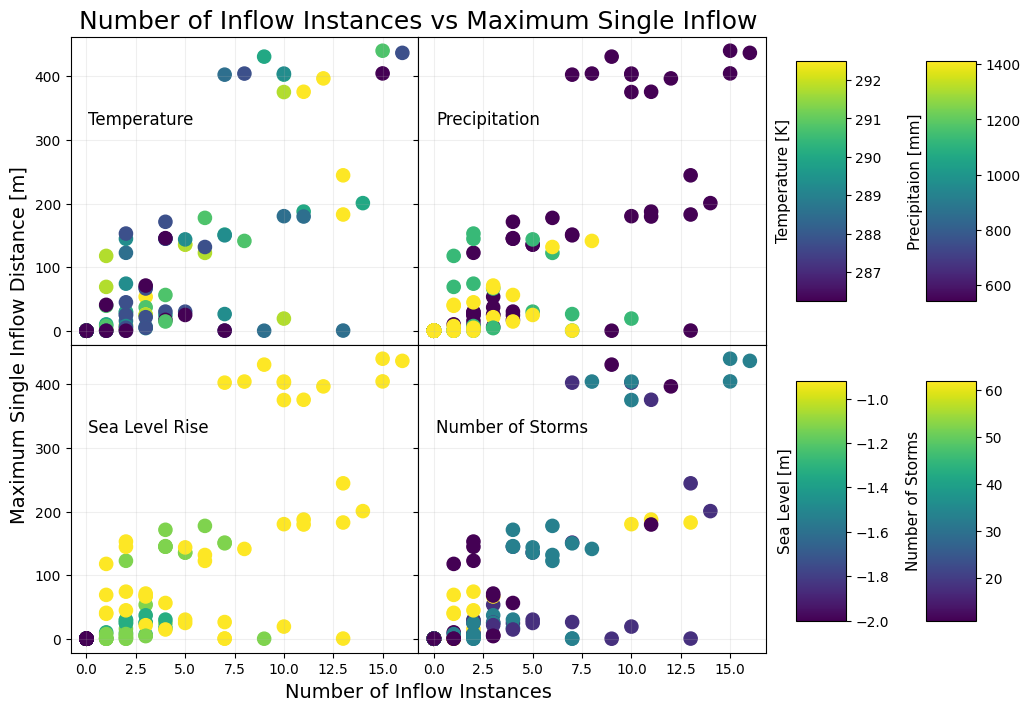

In [494]:
fig, ax = plt.subplots(2,2, figsize=(10,8))
plt.subplots_adjust(left=None, bottom=None, right=0.82, top=None, wspace=0, hspace=0)

im1 = ax[0,0].scatter(groups, dist_1x_all, c=t_all, s = 90)
ax[0,0].grid(alpha = 0.2)
ax[0,0].set_ylabel("Maximum Single Inflow Distance [m]", y = 0, fontsize = 14)
ax[0,0].text(0.1, 325, "Temperature", fontsize=12)

im2 = ax[0,1].scatter(groups, dist_1x_all, c=p_all, s = 90)
ax[0,1].grid(alpha = 0.2)
ax[0,1].tick_params(labelleft=False)
ax[0,1].text(0.1, 325, "Precipitation", fontsize=12)

im3 = ax[1,0].scatter(groups, dist_1x_all, c=slr_all, s = 90)
ax[1,0].grid(alpha = 0.2)
ax[1,0].set_xlabel("Number of Inflow Instances", fontsize = 14, x = 1)
ax[1,0].text(0.1, 325, "Sea Level Rise", fontsize=12)

im4 = ax[1,1].scatter(groups, dist_1x_all, c=s_all, s = 90)
ax[1,1].grid(alpha = 0.2)
ax[1,1].tick_params(labelleft=False)
ax[1,1].text(0.1, 325, "Number of Storms", fontsize=12)

cbar_ax1 = fig.add_axes([0.85, 0.55, 0.05, 0.3])
cb1 = fig.colorbar(im1, cax=cbar_ax1)
cb1.set_label('Temperature [K]', rotation=90, labelpad=-76, fontsize=11)

cbar_ax2 = fig.add_axes([0.98, 0.55, 0.05, 0.3])
cb2 = fig.colorbar(im2, cax=cbar_ax2)
cb2.set_label('Precipitaion [mm]', rotation=90, labelpad=-81, fontsize=11)

cbar_ax3 = fig.add_axes([0.85, 0.15, 0.05, 0.3])
cb3 = fig.colorbar(im3, cax=cbar_ax3)
cb3.set_label('Sea Level [m]', rotation=90, labelpad=-80, fontsize=11)

cbar_ax4 = fig.add_axes([0.98, 0.15, 0.05, 0.3])
cb4 = fig.colorbar(im4, cax=cbar_ax4)
cb4.set_label('Number of Storms', rotation=90, labelpad=-70, fontsize=11)

fig.add_subplot(111, frameon=False)
plt.title("Number of Inflow Instances vs Maximum Single Inflow", fontsize=18)
plt.yticks([])
plt.xticks([])

([], [])

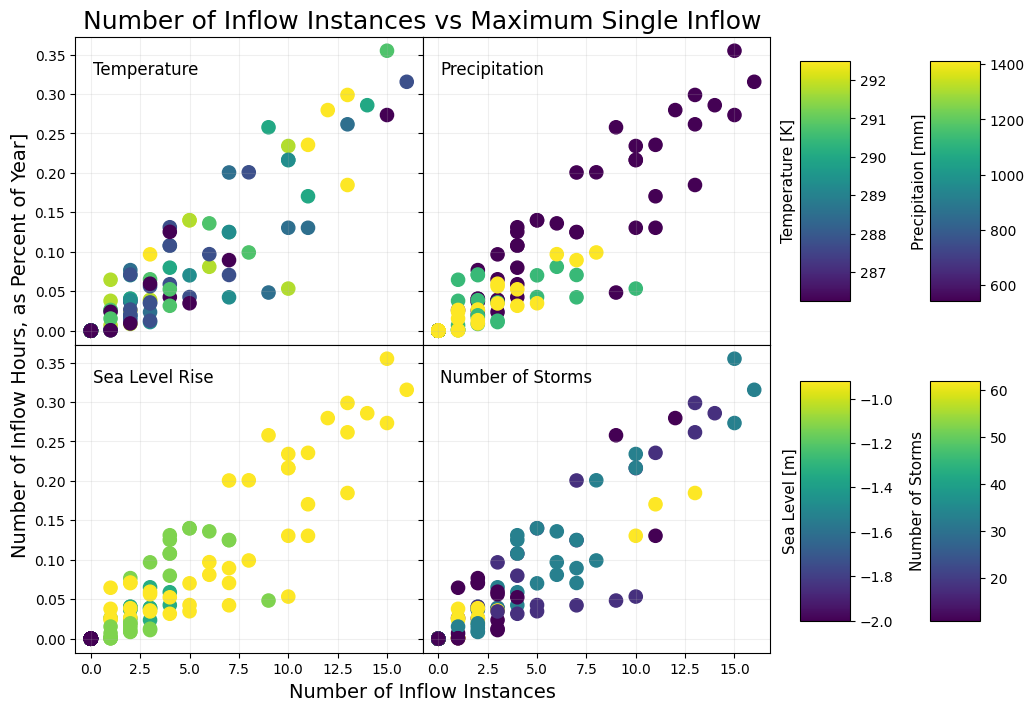

In [496]:
fig, ax = plt.subplots(2,2, figsize=(10,8))
plt.subplots_adjust(left=None, bottom=None, right=0.82, top=None, wspace=0, hspace=0)

im1 = ax[0,0].scatter(groups, sub_zero_all/8760, c=t_all, s = 90)
ax[0,0].grid(alpha = 0.2)
ax[0,0].set_ylabel("Number of Inflow Hours, as Percent of Year]", y = 0, fontsize = 14)
ax[0,0].text(0.1, .325, "Temperature", fontsize=12)

im2 = ax[0,1].scatter(groups, sub_zero_all/8760, c=p_all, s = 90)
ax[0,1].grid(alpha = 0.2)
ax[0,1].tick_params(labelleft=False)
ax[0,1].text(0.1, .325, "Precipitation", fontsize=12)

im3 = ax[1,0].scatter(groups, sub_zero_all/8760, c=slr_all, s = 90)
ax[1,0].grid(alpha = 0.2)
ax[1,0].set_xlabel("Number of Inflow Instances", fontsize = 14, x = 1)
ax[1,0].text(0.1, .325, "Sea Level Rise", fontsize=12)

im4 = ax[1,1].scatter(groups, sub_zero_all/8760, c=s_all, s = 90)
ax[1,1].grid(alpha = 0.2)
ax[1,1].tick_params(labelleft=False)
ax[1,1].text(0.1, .325, "Number of Storms", fontsize=12)

cbar_ax1 = fig.add_axes([0.85, 0.55, 0.05, 0.3])
cb1 = fig.colorbar(im1, cax=cbar_ax1)
cb1.set_label('Temperature [K]', rotation=90, labelpad=-76, fontsize=11)

cbar_ax2 = fig.add_axes([0.98, 0.55, 0.05, 0.3])
cb2 = fig.colorbar(im2, cax=cbar_ax2)
cb2.set_label('Precipitaion [mm]', rotation=90, labelpad=-81, fontsize=11)

cbar_ax3 = fig.add_axes([0.85, 0.15, 0.05, 0.3])
cb3 = fig.colorbar(im3, cax=cbar_ax3)
cb3.set_label('Sea Level [m]', rotation=90, labelpad=-80, fontsize=11)

cbar_ax4 = fig.add_axes([0.98, 0.15, 0.05, 0.3])
cb4 = fig.colorbar(im4, cax=cbar_ax4)
cb4.set_label('Number of Storms', rotation=90, labelpad=-70, fontsize=11)

fig.add_subplot(111, frameon=False)
plt.title("Number of Inflow Instances vs Maximum Single Inflow", fontsize=18)
plt.yticks([])
plt.xticks([])